In [11]:
import math, os, torchvision, torch, glob
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms, datasets
import torch.nn.functional as F
from PIL import Image

> Modificamos el train

In [12]:
root_dir = '/home/chino/VSProjects/Proyecto4/Propuesta/images/'
csv_file = '/home/chino/VSProjects/Proyecto4/Propuesta/train.csv'
csv = pd.read_csv(csv_file)

csv[['numero1', 'numero2']] = csv['image1_image2'].str.split('_', expand=True)
csv['label_num'] = csv['label'].apply(lambda x: 0 if x == 'same' else 1)
csv = csv.drop(columns=["image1_image2", "label"])

csv_invertido = csv[['numero2', 'numero1', 'label_num']].copy()
csv_invertido.columns = ['numero1', 'numero2', 'label_num']

csv = pd.concat([csv, csv_invertido], ignore_index=True)

> Example img transformed


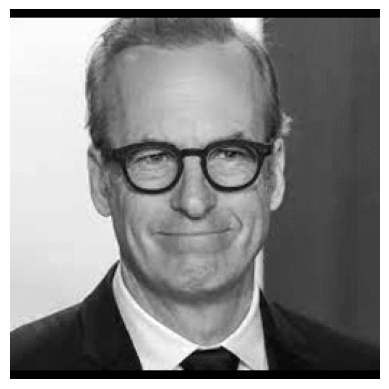

In [37]:
image_path = '/home/chino/VSProjects/Proyecto4/Propuesta/images/13233.png'
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transformed_image = transform(image)
transformed_image_np = transformed_image.numpy().transpose((1, 2, 0))
transformed_image_np = transformed_image_np * 0.5 + 0.5

plt.imshow(transformed_image_np.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

> Creamos el train loader 

In [45]:

transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Definir el Dataset personalizado
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img1_name = os.path.join(self.root_dir, str(self.dataframe.iloc[idx, 0]) + '.png')
        img2_name = os.path.join(self.root_dir, str(self.dataframe.iloc[idx, 1]) + '.png')
        label = self.dataframe.iloc[idx, 2]

        img1 = Image.open(img1_name).convert('RGB')
        img2 = Image.open(img2_name).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        #return img1, img2, torch.tensor([label], dtype=torch.float32)
        return img1, img2, torch.tensor(label, dtype=torch.float32)


dataset = CustomImageDataset(dataframe=csv, root_dir=root_dir, transform=transform)
batch_size = 16
train_len = 0.8
train_dataset, test_dataset = random_split(dataset, [train_len, (1-train_len)], generator=torch.Generator().manual_seed(10))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)



In [46]:
for batch_idx, (img1, img2, label) in enumerate(train_dataloader):
    print(f"Batch train {batch_idx}: img1 shape {img1.shape}, img2 shape {img2.shape}, label shape {label.shape}")
print("Test loading")
for batch_idx, (img1, img2, label) in enumerate(test_dataloader):
    print(f"Batch test {batch_idx}: img1 shape {img1.shape}, img2 shape {img2.shape}, label shape {label.shape}")

Batch train 0: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 1: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 2: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 3: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 4: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 5: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 6: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 7: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)       

cuda:0


### Modelo:

In [14]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [15]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )   
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=6, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(64*5*5, 1024)
        self.dropout_fc1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout_fc2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)

    def forward_once(self, x):
        out = self.layer1(x)
        out = self.bn1(out)
        out = self.layer2(out)
        out = self.bn2(out)
        out = self.layer3(out)
        out = self.bn3(out)
        out = self.layer4(out)
        out = self.bn4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout_fc1(out)
        out = self.fc2(out)
        out = self.dropout_fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out
        
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2




### Training

In [47]:
def train(model, train_loader, Epochs, loss_fn, optimizer, scheduler):
    train_loss = []
    train_time = []
    medium_loss = []
    for epoch in range(Epochs):
        model.train()
        med_loss= 0
        counter = 0

        for batch_idx, (img1, img2, label) in enumerate(train_loader):

            image1 = img1.to(device)
            image2 = img2.to(device)
            label = label.to(device)
            output1, output2 = model(image1,image2)
             
            #Using BCEWithLogisticLoss
            loss = loss_fn(F.pairwise_distance(output1, output2), label)

            #Usar esta linea para ContrastiveLoss
            #Usar esta linea para CosineDistance
            #loss = loss_fn(output1, output2, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            med_loss+=abs(loss.item())
            counter+=1
            train_loss.append(loss.item())
            train_time.append(batch_idx)
            if (batch_idx + 1) % 5 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch + 1, Epochs, batch_idx + 1, len(train_loader), loss.item()))

        medium_loss.append(med_loss/counter)
        # Para activar el scheduler
        #scheduler.step()
    
    print('Finished Training Trainset')
    return train_loss, train_time, medium_loss

            



In [51]:
siamese_nn = SiameseNetwork()
optimizer = torch.optim.Adam(params=siamese_nn.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = ContrastiveLoss()
#loss_fn = nn.HingeEmbeddingLoss(margin=1.0)
#loss_fn = nn.CosineEmbeddingLoss(margin=0.5)
    
epochs = 60

            
model = siamese_nn.to(device)

loss_result, time_result, medium_loss = train(model, train_dataloader, epochs, loss_fn, optimizer, scheduler)


Epoch [1/60], Step [5/221], Loss: 0.878186821937561
Epoch [1/60], Step [10/221], Loss: 0.7991811037063599
Epoch [1/60], Step [15/221], Loss: 0.7007322907447815
Epoch [1/60], Step [20/221], Loss: 0.7883442640304565
Epoch [1/60], Step [25/221], Loss: 0.5630516409873962
Epoch [1/60], Step [30/221], Loss: 0.8320966362953186
Epoch [1/60], Step [35/221], Loss: 0.7566875219345093
Epoch [1/60], Step [40/221], Loss: 0.6069406270980835
Epoch [1/60], Step [45/221], Loss: 0.7485195398330688
Epoch [1/60], Step [50/221], Loss: 0.5132544040679932
Epoch [1/60], Step [55/221], Loss: 0.7985547780990601
Epoch [1/60], Step [60/221], Loss: 0.696625292301178
Epoch [1/60], Step [65/221], Loss: 0.5966234803199768
Epoch [1/60], Step [70/221], Loss: 0.8139658570289612
Epoch [1/60], Step [75/221], Loss: 0.7536014914512634
Epoch [1/60], Step [80/221], Loss: 0.7275699377059937
Epoch [1/60], Step [85/221], Loss: 0.7937999963760376
Epoch [1/60], Step [90/221], Loss: 0.8098853826522827
Epoch [1/60], Step [95/221], Lo

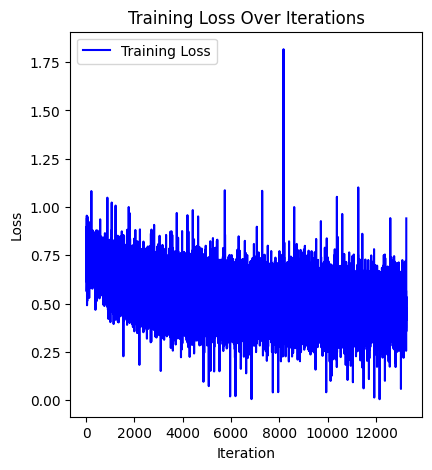

In [53]:
# Plot the loss function    
plt.figure(figsize=(10, 5))

# Plot the loss 
plt.subplot(1, 2, 1)
plt.plot(loss_result, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

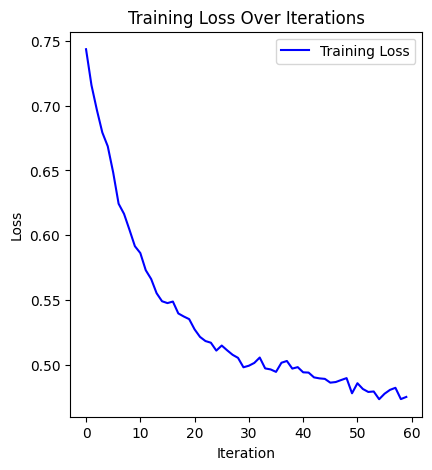

In [54]:
# Plot the loss function
plt.figure(figsize=(10, 5))
        
# Plot the los                                          s
plt.subplot(1, 2, 1)
plt.plot(medium_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

In [18]:
model = torch.load('ModelContrastive60.pth', map_location=device)
model.to(device)

SiameseNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1600, out_features=1024, bias=True)
  (dropout_fc1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
 

> Testing

In [59]:
def test(model, test_loader, threshold=0.5):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        correct = 0
        total = 0
        for idx, (img1, img2, labels) in enumerate(test_loader):
            image1 = img1.to(device)
            image2 = img2.to(device)
            labels = labels.to(device)

            output1, output2 = model(image1, image2)
                
            # Calcular la similitud del coseno
            #cosine_similarity = nn.functional.cosine_similarity(output1, output2)

            # Calcular la distancia por pares para Constrive y BCE
            cosine_similarity = F.pairwise_distance(output1, output2)

            
            # Convertir la similitud del coseno a predicciones (1 si similares, -1 si no)
            #predictions = torch.where(cosine_similarity > threshold, torch.tensor(1.0), torch.tensor(-1.0))

            # Convertir la similitud del coseno a predicciones (0 si similares, 1 si no)
            predictions = torch.where(cosine_similarity > threshold, torch.tensor(1.0), torch.tensor(0.0))


            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += 1
            correct += (predictions == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy, correct, total, all_predictions, all_labels

In [60]:
test_accuracy, correct, total, all_predictions, all_labels = test(model, test_dataloader)
    
print("\nTest Accuracy:  ", test_accuracy)
print("Correct:  ", correct)
print("Total:  ", total)




Test Accuracy:   86.12059158134244
Correct:   757
Total:   879


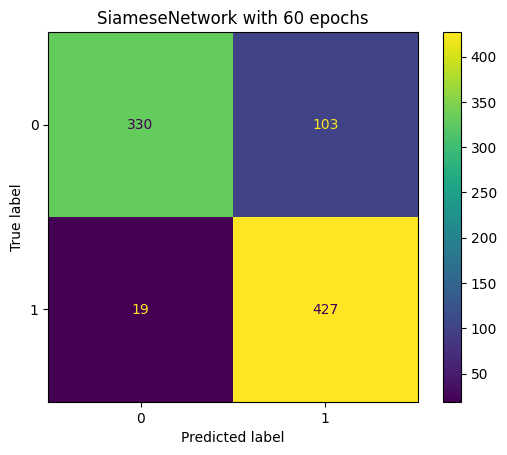

In [61]:
# Crear la matriz de confusión
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title("SiameseNetwork with 60 epochs")
plt.show()

> Submission

In [27]:
csv_file = '/home/chino/VSProjects/Proyecto4/Propuesta/testing_opt.csv'
csv_test = pd.read_csv(csv_file)
csv_test[['numero1', 'numero2']] = csv_test['image1_image2'].str.split('_', expand=True)
csv_test

,image1_image2,numero1,numero2
0,13233_13234,13233,13234
1,13233_13235,13233,13235
2,13234_13235,13234,13235


In [28]:
class SubmissionImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img1_name = os.path.join(self.root_dir, str(self.dataframe.iloc[idx, 1]) + '.png')
        img2_name = os.path.join(self.root_dir, str(self.dataframe.iloc[idx, 2]) + '.png')


        img1 = Image.open(img1_name).convert('RGB')
        img2 = Image.open(img2_name).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2


submission_dataset = SubmissionImageDataset(dataframe=csv_test, root_dir=root_dir, transform=transform)

submission_dataloader = DataLoader(submission_dataset, batch_size=1, shuffle=False)

In [29]:

threshold = 0.5
model.eval()
preds = []
with torch.no_grad():
    for idx, (image1, image2) in enumerate(submission_dataloader):
        image1 = image1.to(device)
        image2 = image2.to(device)
        output1, output2 = model(image1, image2)
        cosine_similarity = F.pairwise_distance(output1, output2)
        
        print("Indice de similitud: ",cosine_similarity)
        predictions = torch.where(cosine_similarity > threshold, torch.tensor(1.0), torch.tensor(0.0))
        preds.append('same' if predictions.item() == 0 else 'diff')
        
csv_test['predicciones'] = preds

tensor([0.4754], device='cuda:0')
tensor([0.3443], device='cuda:0')
tensor([0.5232], device='cuda:0')


In [149]:
csv_test.drop(columns=["numero1","numero2"]).to_csv('submission16.csv', index=False)

In [52]:
torch.save(model, 'ModelBCE60.pth') 